## cdef class callback vs cython ode vs python ode

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from probDE.utils.utils import rand_mat
from scipy.integrate import odeint
%load_ext cython

In [ ]:
%%cython
from libc.math cimport sin
import numpy as np
cimport numpy as np

DTYPE = np.double
ctypedef np.double_t DTYPE_t

cpdef np.ndarray[DTYPE_t, ndim=1] ode_cp(double[::1] x_t, double t, theta=None):
    return np.array([sin(2*t) - x_t[0] - t])

## KalmanODE & KalmanODE_py

In [2]:
from KalmanTest.KalmanODE_py import KalmanODE_py
from probDE.Kalman.ode_init import car_init, indep_ode_init
from probDE.cython.KalmanTest.KalmanODE import KalmanODE

In [3]:
from math import sin
def ode_py(x_t, t, theta=None):
    return np.array([sin(2*t) - x_t[0]])

In [4]:
# These parameters define the order of the ODE and the CAR(p) process
n_meas = 1
n_state = 4

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_steps = 50
n_eval = n_steps-1
tmin = 0
tmax = 10

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
tau = 50
sigma = .5

# Initial value, x0, for the IVP
w = np.array([0., 0., 1.])
x0 = np.array([-1., 0., 1.]) #Initial State
z_states = rand_mat(2*n_steps, n_state) #Random matrix

In [5]:
# Get parameters needed to run the solver
dt = (tmax-tmin)/n_steps
kinit = indep_ode_init([car_init(n_state, tau, sigma, dt, w, x0)], n_state)
x0_state = kinit[-1]

# Python
kalmanode_py = KalmanODE_py.initialize(kinit, n_state, n_meas, tmin, tmax, n_eval, ode_py) # Initialize the class
kalmanode_py.z_states = z_states
kalman_py_sim, kalman_py_mu, kalman_py_var = kalmanode_py.solve(x0_state, mv=True, sim=True)

# Cython
kalmanode = KalmanODE.initialize(kinit, n_state, n_meas, tmin, tmax, n_eval, ode_py) # Initialize the class
kalmanode.z_states = z_states
kalman_sim, kalman_mu, kalman_var = kalmanode.solve(x0_state, mv=True, sim=True)

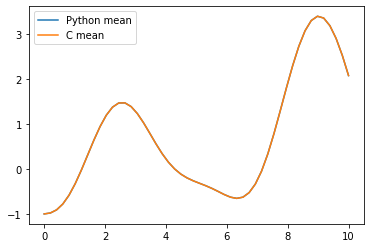

In [6]:
tseq = np.linspace(tmin, tmax, n_steps)
plt.plot(tseq, kalman_py_sim[:, 0], label = 'Python mean')
plt.plot(tseq, kalman_sim[:, 0], label = 'C mean')
plt.legend(loc='upper left')

In [ ]:
kalman_cy = %timeit -o -n 100 _, _, _ = kalmanode.solve(x0_state, mv=True, sim=True)

In [ ]:
kalman_py = %timeit -o -n 100 _, _, _ = kalmanode_py.solve(x0_state, mv=True, sim=True)

In [ ]:
kalman_py.average/kalman_cy.average

## Lorenz63

In [12]:
def lorenz0(state, t):
    rho = 28.0
    sigma = 10.0
    beta = 8.0 / 3.0
    x, y, z = state  # Unpack the state vector
    return -sigma*x + sigma*y, rho*x - y -x*z, -beta*z + x*y

In [13]:
# RHS of ODE
def lorenz(X_t, t, theta=None):
    rho = 28.0
    sigma = 10.0
    beta = 8.0 / 3.0
    p = 3
    x, y, z = X_t[p*0], X_t[p*1], X_t[p*2]
    return np.array([-sigma*x + sigma*y, rho*x - y -x*z, -beta*z + x*y]) 

# LHS Matrix of ODE
w_mat = np.array([[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]])

# These parameters define the order of the ODE and the CAR(p) process
n_meas = 3
n_state = 9 # number of continuous derivatives of CAR(p) solution prior
n_state1 = n_state2 = n_state3 = 3

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_steps = 5000 
n_eval = n_steps -1
tmin = 0
tmax = 20

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
tau = 1
sigma = .001
scale = 10 # Scaling factor for root generation

# Initial value, x0, for the IVP
x0 = [-12, -5, 38]
v0 = lorenz0(x0, 0)
x0 = np.column_stack([x0, v0])
z_states = rand_mat(2*n_steps, n_state)

In [14]:
# Get parameters needed to run the solver
dt = (tmax-tmin)/n_steps
kinit = indep_ode_init([car_init(n_state1, tau, sigma, dt, w_mat[0], x0[0], scale),
                        car_init(n_state2, tau, sigma, dt, w_mat[1], x0[1], scale),
                        car_init(n_state3, tau, sigma, dt, w_mat[2], x0[2], scale)], n_state)
x0_state = kinit[-1]

# Python
kalmanode_py = KalmanODE_py.initialize(kinit, n_state, n_meas, tmin, tmax, n_eval, lorenz) # Initialize the class
kalmanode_py.z_states = z_states # Set random states (not necessary)
kalman_py_lor_sim, kalman_py_lor_mu, kalman_py_lor_var = kalmanode_py.solve(x0_state, mv=True, sim=True) 

# Cython
kalmanode = KalmanODE.initialize(kinit, n_state, n_meas, tmin, tmax, n_eval, lorenz) # Initialize the class
kalmanode.z_states = z_states # Set random states (not necessary)
kalman_lor_sim, kalman_lor_mu, kalman_lor_var = kalmanode.solve(x0_state, mv=True, sim=True)

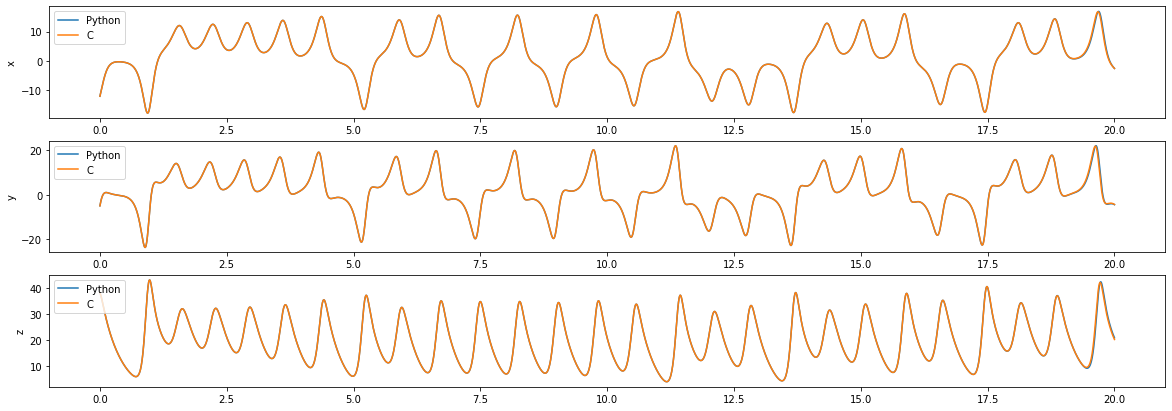

In [15]:
tseq = np.linspace(tmin, tmax, n_steps)
n_var = 3
_, axs = plt.subplots(n_var, 1, figsize=(20, 7))
ylabel = ['x', 'y', 'z']
for i in range(n_var):
    axs[i].plot(tseq, kalman_py_lor_sim[:, n_state1*i], label="Python")
    axs[i].plot(tseq, kalman_lor_sim[:, n_state1*i], label="C")
    axs[i].set_ylabel(ylabel[i])
    axs[i].legend(loc='upper left')

In [ ]:
kalman_lor_cy = %timeit -o _ = kalmanode.solve(x0_state, mv=True, sim=True)

In [ ]:
kalman_lor_py = %timeit -o _, _, _ = kalmanode_py.solve(x0_state, mv=True, sim=True)

In [ ]:
kalman_lor_py.average/kalman_lor_cy.average

## Lane-Emden

In [16]:
def lane0(x_t, t):
    return [x_t[1], -2/t*x_t[1] - x_t[0]]

In [17]:
def lane(x_t, t, theta=None):
    return np.array([-2/t*x_t[1] - x_t[0]])

# These parameters define the order of the ODE and the CAR(p) process
n_meas = 1
n_state = 3

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_steps = 500
n_eval = n_steps-1 
tmin = 1
tmax = 10

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
tau = 50
sigma = .001

# Initial value, x0, for the IVP
w = np.array([0., 0., 1.])
x0 = np.array([1., 0., -1.]) #Initial State
z_states = rand_mat(2*n_steps, n_state) #Random matrix

In [18]:
# Get parameters needed to run the solver
dt = (tmax-tmin)/n_steps
kinit = indep_ode_init([car_init(n_state, tau, sigma, dt, w, x0)], n_state)
x0_state = kinit[-1]

# Python
kalmanode_py = KalmanODE_py.initialize(kinit, n_state, n_meas, tmin, tmax, n_eval, lane) # Initialize the class
kalman_py_lane_sim, kalman_py_lane_mu, kalman_py_lane_var = kalmanode_py.solve(x0_state, mv=True, sim=True) 

# Cython
kalmanode = KalmanODE.initialize(kinit, n_state, n_meas, tmin, tmax, n_eval, lane) # Initialize the class
kalman_lane_sim, kalman_lane_mu, kalman_lane_var = kalmanode.solve(x0_state, mv=True, sim=True)

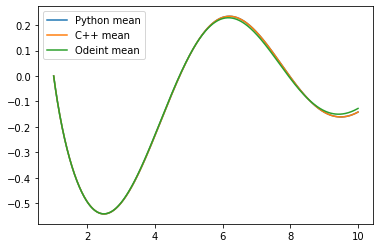

In [19]:
tseq = np.linspace(tmin, tmax, n_steps)
lane_odeint = odeint(lane0, [1, 0], tseq)
plt.plot(tseq, kalman_py_lane_sim[:, 1], label = 'Python mean')
plt.plot(tseq, kalman_lane_sim[:, 1], label = 'C++ mean')
plt.plot(tseq, lane_odeint[:, 1], label = 'Odeint mean')
plt.legend(loc='upper left')

In [ ]:
kalman_lane_cy = %timeit -o _ = kalmanode.solve(x0_state, mv=True, sim=True)

In [ ]:
kalman_lane_py = %timeit -o _, _, _ = kalmanode_py.solve(x0_state, mv=True, sim=True)

In [ ]:
kalman_lane_py.average/kalman_lane_cy.average

## FitzHugh-Nagumo

- The ODE model is

    $$
    \frac{dV_t}{dt} = c(V_t - V_t^3/3 + R_t), \qquad \frac{d R_t}{dt} = -(V_t - a + b R_t)/c.
    $$

- The true parameter values are $a = .2$, $b = .2$, $c = 3$.

- The parameter priors are $\theta_j \stackrel{ind}{\sim} \mathrm{LogNormal}(\theta_{\star j}, 1)$, where $\theta_j \in \{a, b, c\}$ and $\theta_{\star j}$ is the corresponding true parameter value.

- Data is observed at time points $t = 1, 2, \ldots, 40$, with some error.  That is,

    $$
    y_{1n} \stackrel{ind}{\sim} \mathcal N(V_n, .01^2), \qquad y_{2n} \stackrel{ind}{\sim} \mathcal N(R_n, .01^2) 
    $$

- The step sizes for the discretization are $h = (.005, .01, .02, .05, .1)$.

### API

In [20]:
def fitz0(X_t, t, theta):
    "FitzHugh-Nagumo ODE function."
    a, b, c = theta
    V, R = X_t
    return [c*(V - V**3/3 + R), -1/c*(V - a + b*R)]

In [24]:
# Bayesian inference class for the FitzHugh-Nagumo model
# public methods:
# - An ODE solver.
# - A simulator.
# - An MCMC sampler.
class Fitz:
    # private members
    def __init__(self, n_state1, n_state2, n_state, n_meas):
        self._n_state1 = n_state1
        self._n_state2 = n_state2
        self._n_state = n_state
        self._n_meas = n_meas
    
    def _fitz(self, X_t, t, theta):
        "FitzHugh-Nagumo ODE function."
        a, b, c = theta
        V, R = X_t[0], X_t[self._n_state1]
        return [c*(V - V**3/3 + R), -1/c*(V - a + b*R)]
    
    def _normal_lpdf(self, y, mean, std):
        loglik = -0.5*(np.log(2*np.pi) + np.log(std*std) + np.sum((y - mean)**2)/(std*std))
        return loglik
    
    def _lognormal_lpdf(self, y, mean, std):
        loglik = -np.log(y) + self._normal_lpdf(np.log(y), mean, std)
        return loglik
    
    def _logprior(self, Y_t, X_t, gamma, theta, theta_true, theta_sd):
        n_obs, n_comp = Y_t.shape
        n_eval = len(X_t)
        n_theta = len(theta0)
        n_skip = n_eval//n_obs
        lpi = 0.
        for j in range(n_comp):
            lpi += self._normal_lpdf(Y_t[:, j], X_t[::n_skip, self._n_state1*j], gamma)
        for i in range(n_theta):
            lpi += self._lognormal_lpdf(theta[i], theta_true[i], theta_sd[i])
        return lpi
    
    def simulate(self, tmin, tmax, n_eval, x0, theta, tau, sigma, w_mat, gamma):
        # let's make gamma = sqrt(Gamma)
        dt = (tmax - tmin)/(n_eval+1)
        kinit = indep_ode_init([car_init(self._n_state1, tau[0], sigma[0], dt, w_mat[0], x0[0]),
                                car_init(self._n_state2, tau[1], sigma[1], dt, w_mat[1], x0[1])],
                                self._n_state)
        kode = KalmanODE.initialize(kinit, self._n_state, self._n_meas, tmin, tmax, n_eval, self._fitz)
        x0_state = kinit[-1]
        X_t = kode.solve(x0_state, theta=theta) # ODE no noise
        Y_t = X_t + gamma*np.random.randn() # include noise
        del kode
        return Y_t, X_t

    def mwg(self, n_samples, Y_t, tmin, tmax, n_eval, w_mat, x0, 
            theta0, theta_true, theta_sd, gamma, tau, sigma, rwsd, accept = False):
        
        # Get problem dimensions and initialization
        n_theta = len(theta0)
        theta_curr = theta0.copy()
        theta_prop = theta0.copy() 
        paccept = np.zeros(n_theta, dtype=int)
        Theta = np.zeros((n_samples, n_theta))
        
        # MCMC process
        dt = (tmax - tmin)/(n_eval+1)
        kinit = indep_ode_init([car_init(self._n_state1, tau[0], sigma[0], dt, w_mat[0], x0[0]),
                                car_init(self._n_state2, tau[1], sigma[1], dt, w_mat[1], x0[1])],
                                self._n_state)
        x0_state = kinit[-1]
        kode = KalmanODE.initialize(kinit, self._n_state, self._n_meas, tmin, tmax, n_eval, self._fitz)
        X_curr = kode.solve(x0_state, theta=theta_curr)
        lp_curr = self._logprior(Y_t, X_curr, gamma, theta_curr, theta_true, theta_sd)
        for i in range(n_samples):
            for j in range(n_theta):
                theta_prop[j] += rwsd[j]*np.random.randn()
                if theta_prop[j]>0:
                    v0 = self._fitz(x0_state, 0, theta_prop)
                    x0_state[[1, self._n_state1+1]] = v0
                    del kode.z_states
                    X_prop = kode.solve(x0_state, theta=theta_prop)
                    lp_prop = self._logprior(Y_t, X_prop, gamma, theta_prop, theta_true, theta_sd)
                    lacc = lp_prop - lp_curr
                    if lacc > 0 or np.random.uniform() < np.exp(lacc):
                        theta_curr[j] = theta_prop[j]
                        lp_curr = lp_prop
                        paccept[j] = paccept[j] + 1
                    else:
                        theta_prop[j] = theta_curr[j]
                else:
                    theta_prop[j] = theta_curr[j]
            # storage
            Theta[i] = theta_curr
        # output
        if not accept:
            return Theta
        else:
            paccept = paccept/n_samples
            return Theta, paccept
        
    def mwg_det(self, n_samples, Y_t, tmin, tmax, n_eval, w_mat, x0, 
            theta0, theta_true, theta_sd, gamma, tau, sigma, rwsd, accept = False):
        
        # Get problem dimensions and initialization
        n_theta = len(theta0)
        theta_curr = theta0.copy()
        theta_prop = theta0.copy() 
        paccept = np.zeros(n_theta, dtype=int)
        Theta = np.zeros((n_samples, n_theta))
        
        # MCMC process
        tseq = np.linspace(tmin, tmax, n_eval+1)
        X_curr = odeint(fitz0, x0, tseq, args=(theta_curr,))
        self._n_state1 = 1
        self._n_state2 = 1
        lp_curr = self._logprior(Y_t, X_curr, gamma, theta_curr, theta_true, theta_sd)
        for i in range(n_samples):
            for j in range(n_theta):
                theta_prop[j] += rwsd[j]*np.random.randn()
                if theta_prop[j]>0:
                    X_prop = odeint(fitz0, x0, tseq, args=(theta_prop,))
                    lp_prop = self._logprior(Y_t, X_prop, gamma, theta_prop, theta_true, theta_sd)
                    lacc = lp_prop - lp_curr
                    if lacc > 0 or np.random.uniform() < np.exp(lacc):
                        theta_curr[j] = theta_prop[j]
                        lp_curr = lp_prop
                        paccept[j] = paccept[j] + 1
                    else:
                        theta_prop[j] = theta_curr[j]
                else:
                    theta_prop[j] = theta_curr[j]
            # storage
            Theta[i] = theta_curr
        # output
        if not accept:
            return Theta
        else:
            paccept = paccept/n_samples
            return Theta, paccept

In [25]:
# These parameters define the order of the ODE and the CAR(p) process
n_state1 = 3 # State dimension of V_n
n_state2 = 3 # State dimension of R_n
n_state = 6 # Total state
n_meas = 2 # Total measures

# it is assumed that the solution is sought on the interval [tmin, tmax].
tmin = 0 
tmax = 40
n_steps = 400
n_eval = n_steps - 1

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
n_var = 2
tau = [100]*n_var
sigma = [.01]*n_var

# Initial value, a, for the IVP
theta_true = np.array([0.2, 0.2, 3])
x0 = [-1, 1]
v0 = fitz0(x0, 0, theta_true)
x0 = np.column_stack([x0, v0])
w_mat = np.array([[0.0, 1.0], [0.0, 1.0]])

# Noise for data generation
gamma = 0.01

In [26]:
theta0 = np.array([0.1, 0.1, 2.6]) # Initial theta
theta_true = np.array([.2, .2, 3]) # True theta
n_theta = len(theta0)
theta_sd = np.ones(n_theta) # lognormal theta variance
rwsd = np.array([.01, .01, .01]) # Variance of proposal generation
n_samples = 500

# Initialize Fitz class and simulate data
fitz = Fitz(n_state1, n_state2, n_state, n_meas)
Y_t, X_t = fitz.simulate(tmin, tmax, n_eval, x0, theta_true, tau, sigma, w_mat, gamma)
Theta = fitz.mwg(n_samples, Y_t[:, [0,3]], tmin, tmax, n_eval, w_mat, x0, theta0, 
                 theta_true, theta_sd, gamma, tau, sigma, rwsd)

In [ ]:
tseq = np.linspace(tmin, tmax, n_eval+1)
X_t = odeint(fitz0, [-1, 1], tseq, args=(theta_true,))
Y_t = X_t + gamma*np.random.randn() # include noise
Theta_det = fitz.mwg_det(n_samples, Y_t, tmin, tmax, n_eval, w_mat, x0[0], theta0, 
                 theta_true, theta_sd, gamma, tau, sigma, rwsd)

In [ ]:
n_samples = 10000
fitz = Fitz(n_state1, n_state2, n_state, n_meas)
Y_t, X_t = fitz.simulate(tmin, tmax, n_eval, x0, theta_true, tau, sigma, w_mat, gamma)
kalman_fitz_cy2 = %timeit -o -n1 -r1 _=  \
fitz.mwg(n_samples, Y_t[:, [0, 3]], tmin, tmax, n_eval, w_mat, x0, theta0, theta_true, theta_sd, gamma, tau, sigma, rwsd)

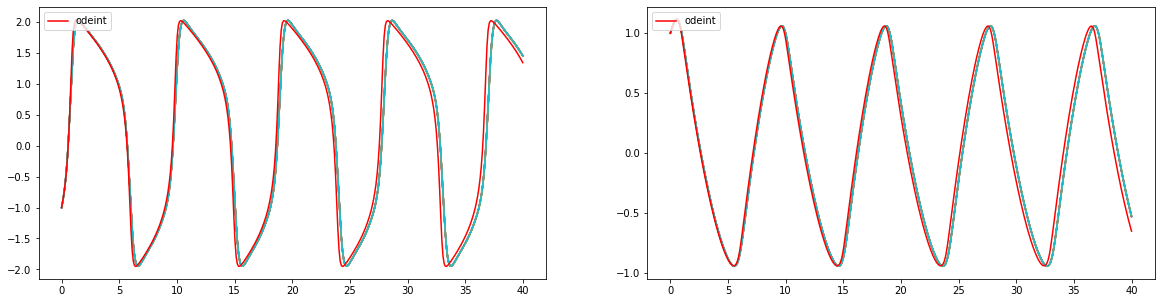

In [29]:
n_runs = 10
n_steps = 400
n_eval = n_steps - 1
kfitz_Xt = np.zeros((n_runs, n_steps, 2))
fitz = Fitz(n_state1, n_state2, n_state, n_meas)
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
tseq = np.linspace(tmin, tmax, n_steps)
ofitz_Xt = odeint(fitz0, [-1, 1], tseq, args=(theta_true,))
for i in range(10):
    _, X_t = fitz.simulate(tmin, tmax, n_eval, x0, theta_true, tau, sigma, w_mat, gamma)
    kfitz_Xt[i] = X_t[:, [0, 3]]
    for j in range(2):
        axs[j].plot(tseq, kfitz_Xt[i, :, j])
for i in range(2):
    axs[i].plot(tseq, ofitz_Xt[:, i], color='r', label='odeint')
    axs[i].legend(loc='upper left')

## Fitz Contour Plots

In [30]:
import seaborn as sns
import matplotlib.patches as mpatches

In [39]:
def theta_plot(Theta, bw=0.1):
    fig, axs = plt.subplots(n_theta, n_theta, sharex='col', figsize=(20, 5))
    patches = [None]*n_h
    for i in range(n_h):
        patches[i] = mpatches.Patch(color='C{}'.format(i), label='h={}'.format(h[i]))
        for row in range(n_theta):
            sns.kdeplot(Theta[i, :, row], bw=bw, ax=axs[row, row])
            for col in range(row):
                sns.kdeplot(Theta[i, :, col], Theta[i, :, row], bw=bw, ax=axs[row, col])

    axs[0,1].set_axis_off()
    axs[0,2].set_axis_off()
    axs[1,2].set_axis_off()
    axs[0,2].legend(handles=patches, loc='center')
    plt.show()

In [32]:
theta0 = np.array([.1, .1, 2.6])
theta_true = np.array([.2, .2, 3])
rwsd = np.array([.01, .01, .01])
n_samples = 500
n_theta = len(theta0)
h = np.array([.1, .05, .02, .01, .005]) 
n_h = len(h)
h_steps = 40/h # Step size
h_steps = h_steps.astype(int)

In [ ]:
fitz_theta = np.zeros((n_h, n_samples, n_theta))
Y_t, X_t = fitz.simulate(tmin, tmax, n_eval, x0, theta_true, tau, sigma, w_mat, gamma)
for i in range(n_h):
    Theta = fitz.mwg(n_samples, Y_t[:, [0,3]], tmin, tmax, h_steps[i]-1, w_mat, x0, theta0, 
                     theta_true, theta_sd, gamma, tau, sigma, rwsd)
    fitz_theta[i] = Theta

In [33]:
fitz_det_theta = np.zeros((n_h, n_samples, n_theta))
tseq = np.linspace(tmin, tmax, n_eval+1)
X_t = odeint(fitz0, [-1, 1], tseq, args=(theta_true,))
Y_t = X_t + gamma*np.random.randn() # include noise
for i in range(n_h):
    Theta_det = fitz.mwg_det(n_samples, Y_t, tmin, tmax, h_steps[i]-1, w_mat, x0[0], theta0, 
                     theta_true, theta_sd, gamma, tau, sigma, rwsd)
    fitz_det_theta[i] = Theta_det

In [ ]:
theta_plot(fitz_theta, .1)

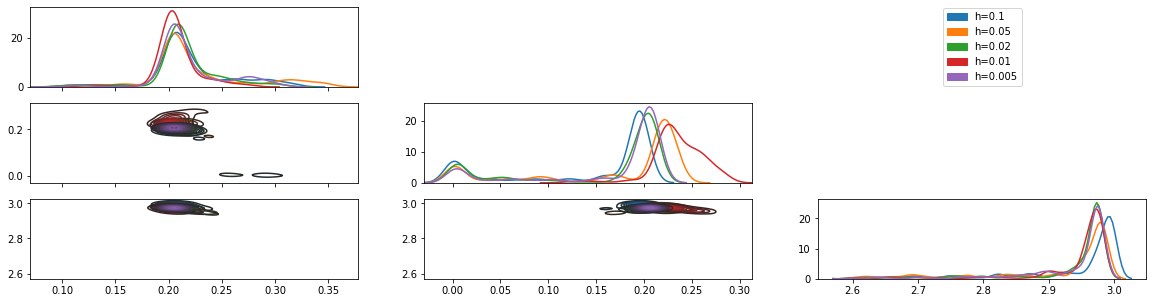

In [41]:
theta_plot(fitz_det_theta, .01)